In [25]:
import numpy as np;
import matplotlib
import matplotlib.pyplot as plt
import scipy.fft
import seaborn as sns;

from data_utils import *

matplotlib.rcParams['figure.dpi'] = 80

DATASET = '/Users/stepanmazokha/Desktop/wisig_raw_rffi_dataset/node1-1/'
FIG_DIR = '/Users/stepanmazokha/Desktop/figs/'

TEST_FILE = 'node14-9.dat'

In [26]:
def wisig_read_raw(dir, file):
    data = np.fromfile(dir + file, dtype=np.float32, count=-1)
    if data.size % 2 != 0:
        raise ValueError("The data size is not even, cannot form complex numbers.")
    return data[::2] + 1j * data[1::2]

iq = wisig_read_raw(DATASET, TEST_FILE)

In [28]:
def find_sequence(iq, pattern, threshold=0.8):
    pattern_length = len(pattern)
    correlations = np.correlate(iq, pattern, mode='valid')
    peaks = (correlations > (threshold * np.max(correlations))).nonzero()[0]
    
    sequences = []
    i = 0
    while i < len(peaks):
        start = peaks[i]
        end = start + pattern_length
        sequences.append((start, end))
        i += pattern_length  # Skip to the next possible sequence
    return np.array(sequences)

def find_sts(iq):
    # Example STS pattern (should be replaced with actual STS pattern)
    sts_pattern = np.array([1, -1, 1, -1, 1, -1, 1, -1])
    return find_sequence(iq, sts_pattern)

def find_lts(iq):
    # Example LTS pattern (should be replaced with actual LTS pattern)
    lts_pattern = np.array([1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1])
    return find_sequence(iq, lts_pattern)

In [45]:
sts = find_sts(iq)
lts = find_lts(iq)


iq.shape

(12800000,)

In [77]:
N = 50
L = 400

M = (2/N) * (L-N) + 1

print(M)

15.0


In [69]:
50/15

3.3333333333333335

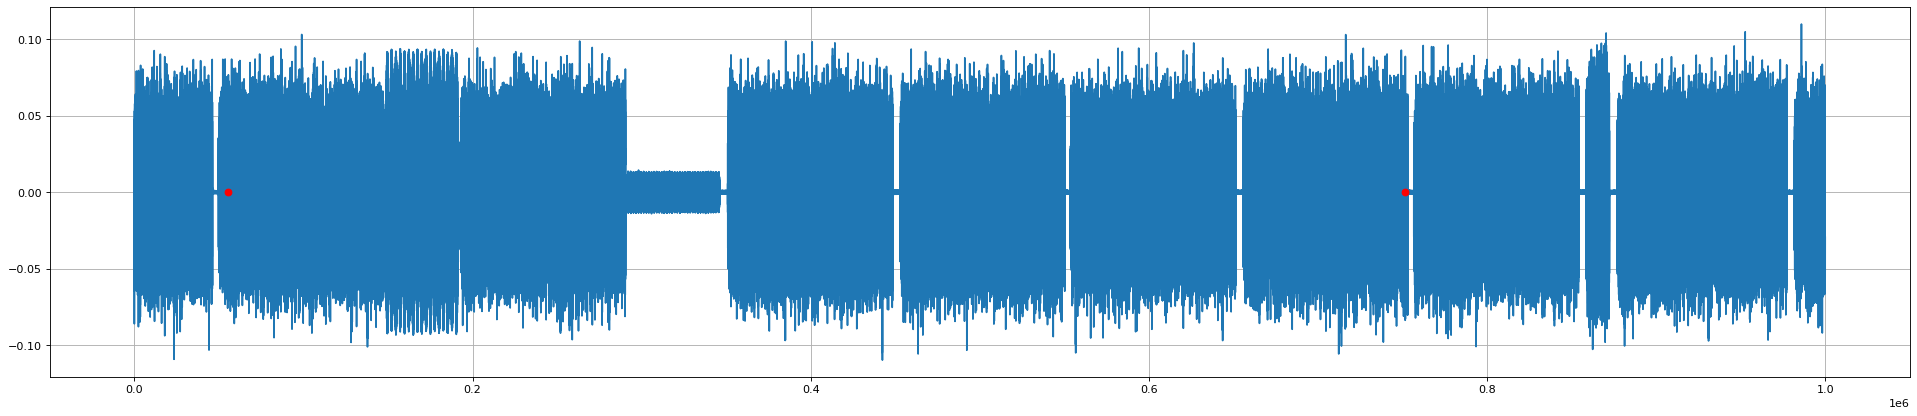

In [51]:
max_iq = 1000000

idx = np.arange(0, max_iq, 1)
plt.figure(figsize=(30, 6))
plt.plot(idx, np.real(iq[idx]))
plt.grid()

for i in np.arange(lts.shape[0]):
    sequence = lts[i, :]
    if sequence[0] <= max_iq:
        plt.plot(sequence[0], 0, 'ro')


In [104]:
def generate_spectrum(data, tx_id, rx_id, date_id, equalized):
    # data shape: [tx(6), rx(12), date(4), equalized? (1-unprocessed, 2-equalized), # of signals(1000), # of samples(256), I/Q split(2)]
    N = 256

    samples = data[tx_id][rx_id][date_id][equalized]

    if len(samples) < 50:
        print("Not enough samples: " + str(len(samples)))
        return

    # Convert into frequency domain (spectrum)
    spectrum = np.zeros(shape=(N-1, 50), dtype='float32')
    for packet_id in np.arange(50):
        packet = np.array(samples[packet_id])
        signal = packet[:, 0] + 1j * packet[:, 1]

        yf = scipy.fft.fft(signal, n=256)
        # xf = scipy.fft.fftfreq(N, T)[:N//2]
        # plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
        # plt.show()

        # Generate channel independent spectrogram.
        yf_ind = yf[1:]/yf[:-1]
        # xf_ind = xf[1:]
        # plt.plot(xf_ind, 2.0/256 * np.abs(yf_ind[0:256//2-1]))
        # plt.show()

        spectrum[:, packet_id] = np.abs(yf_ind)

    spectrum_amp = np.log10(np.abs(spectrum)**2)

    # Plot the spectrogram using seaborn heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(spectrum_amp, cmap='viridis', cbar=True)
    plt.title("Spectrogram")
    plt.xlabel("Packet ID")
    plt.ylabel("Frequency Bin")
    plt.savefig(FIG_DIR + 'spectrogram-' + str(tx_id) + "-" + str(rx_id) + ".png")
    plt.close()

In [106]:
for tx_id in np.arange(1, 30):
    generate_spectrum(data, tx_id, 1, 1, 0)

Not enough samples: 0
Not enough samples: 14
Not enough samples: 0
